# 1.7 Creating Network Visualizations

## This script contains the following:
#### [1. Import Libraries](#import-libraries)
#### [2. Import Data](#import-data)
#### [3. Static Network Graph - NetworkX](#static)
#### [4. Interactive Network Graph - Pyvis](#interactive)
#### [5. Community Detection - Leiden Algorithm](#community-detection)
#### [6. Interactive Network Graph + Output from Community Detection](#interactive-community)
#### [7. Calculate Country Importance in 20th Century Events](#centrality)
    DEGREE CENTRALITY
    CLOSENESS CENTRALITY
    BETWEENNESS CENTRALITY
#### [8. Export Network Visualizations](#export-viz)

### 1. Import Libraries<a class="anchor" id="import-libraries"></a>

In [5]:
%%capture
import pandas as pd
import numpy as np
import networkx as nx
import os
import matplotlib.pyplot as plt
from pyvis.network import Network
import seaborn as sns
import pyvis
from cdlib import algorithms

### 2. Import Data<a class="anchor" id="import-data"></a>

In [7]:
# Import the country relationships table as a dataframe
path = r'/Users/matthewjones/Documents/CareerFoundry/Data Visualization with Python/Achievement 1/20th-Century'

relationship_df = pd.read_csv(os.path.join(path, '02. Data/country_relationships.csv'), index_col = 0)

In [8]:
# Check the output
relationship_df

,source,target,value
0,Germany,Russia,9
1,Austria,Germany,10
2,Austria,Russia,5
3,Austria,Hungary,6
4,Germany,Hungary,9
...,...,...,...
64,Finland,Germany,6
65,Denmark,Germany,6
66,Greece,the United Kingdom,1
67,India,Pakistan,6


### 3. Static Network Graph - NetworkX<a class="anchor" id="static"></a>

In [10]:
# Create a network object from relationship_df
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

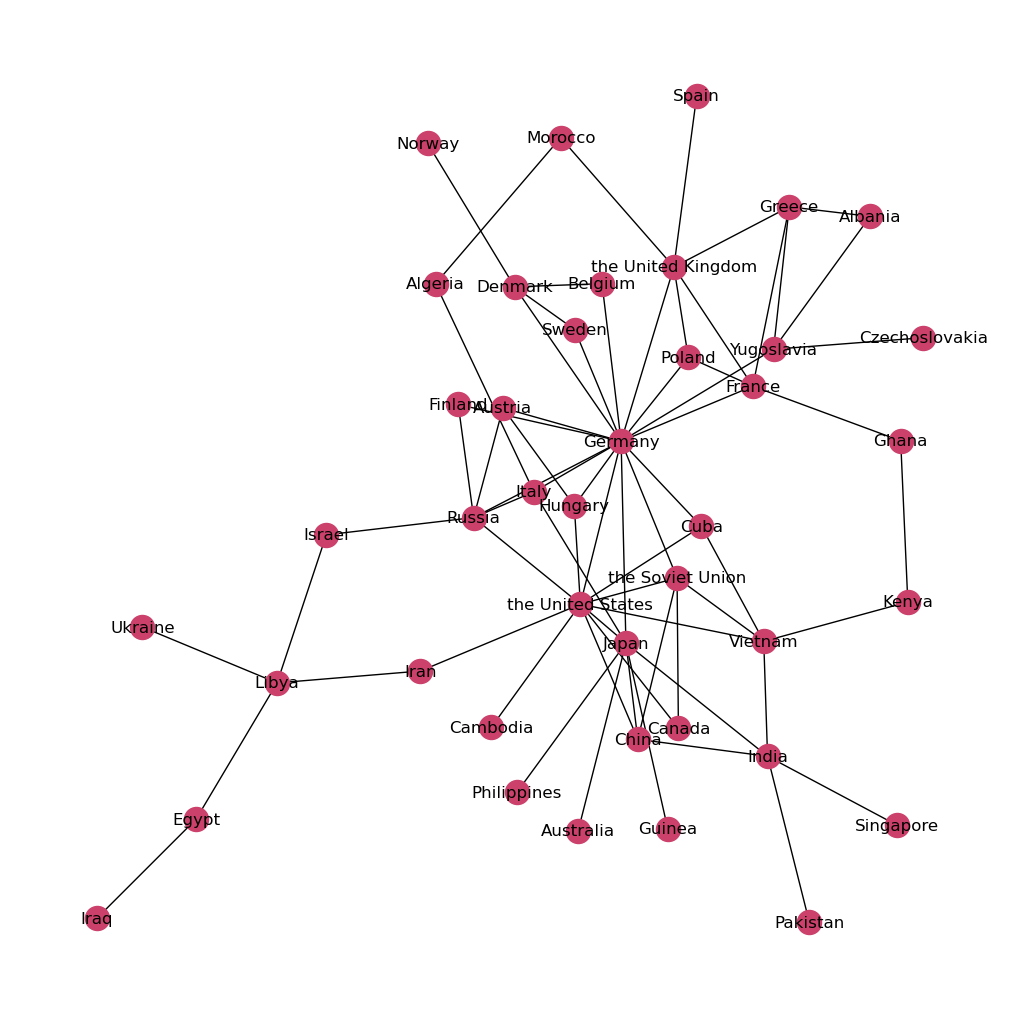

In [11]:
# Graph the network object
h = plt.figure(figsize = (10,10))
pos = nx.kamada_kawai_layout(G) # Define the layout for the graph

nx.draw(G, with_labels = True, node_color = '#cb416b', pos = pos) # Draw the graph
plt.show() 

In [12]:
# Save the network graph
h.savefig(os.path.join(path, '04. Visualizations/networkx_plt_countries.png'))

### 4. Interactive Network Graph - Pyvis<a class="anchor" id="interactive"></a>

In [14]:
# Define a new network object
net = Network()
net = Network(notebook = True, width="1000px", height="1000px", bgcolor='#222222', font_color='white')

# Define nodes from the G object
node_degree = dict(G.degree)

# Set up node size attributes
nx.set_node_attributes(G, node_degree, 'size')
net.from_nx(G)
net.show_buttons(filter_ = True)
net.repulsion() # Space nodes out appropriately
net.show("20th_century_country_relationships.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


### 5. Community Detection - Leiden Algorithm<a class="anchor" id="community-detection"></a>

In [16]:
# Apply the Leiden algorithm to the network object
coms = algorithms.leiden(G)

In [17]:
# Map the community data onto their respective nodes
new_com = coms.to_node_community_map()

In [18]:
# Convert new_com into a dictionary
dict_com = {k:v[0] for k,v in new_com.items()}

In [19]:
#community_colors = {0 : '#0a2344', 1 : '#3b1d4a', 2 : '#6b1650', 3 : '#9c1057', 4 : '#cc095d', 5 : '#fd0363'}
# In future edits, I would like to change the colors of the communities in the network graph

### 6. Interactive Network Graph + Output from Community Detection<a class="anchor" id="interactive-community"></a>

In [21]:
# Re-visualize network graph with the communities as an argument
nx.set_node_attributes(G, dict_com, 'group')
com_net = Network(notebook = True, width="1000px", height="1000px", bgcolor='#222222', font_color='white')

# Define nodes from the G object
com_net.from_nx(G)

# Set up node size attributes
com_net.show_buttons(filter_ = True)
com_net.repulsion() # Space nodes out appropriately
com_net.show("20th_century_country_communities_leiden.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


#### Observations:
    After including the output of the communities algorithm, we can see the connections grouped mainly by geographic location. The countries in Asia are GREEN. The countries in Europe are BLUE or ORANGE, the Blue European countries are mostly central Europe. The countries in the middle east are PINK. And the RED countries, while not grouped by geography, are the countries that were most involved in the Cold War.
    
    This grouping isn't 100% precise, but it does follow a pattern.

### 7. Calculating Country Importance in 20th Century Events<a class="anchor" id="centrality"></a>

#### DEGREE CENTRALITY

In [25]:
# Calculate degree centrality of network object, and convert output into a sorted dataframe
degree_dict = nx.degree_centrality(G)
degree_df = pd.DataFrame(degree_dict.items(), columns=['Countries','Centrality'])
degree_df.sort_values(by = ['Centrality'], ascending=False, inplace = True)
degree_df['Centrality'] = degree_df['Centrality'].apply(lambda x: round(x, 4)) # Round centrality measure to 4 decimal places

In [26]:
# Create a new column in dataframe for Leiden communities
degree_df['Community'] = degree_df['Countries'].map(dict_com)

# When I can customize the colors of the communities, I will check to see coloring 
# the bar chart by community is a valuable effort

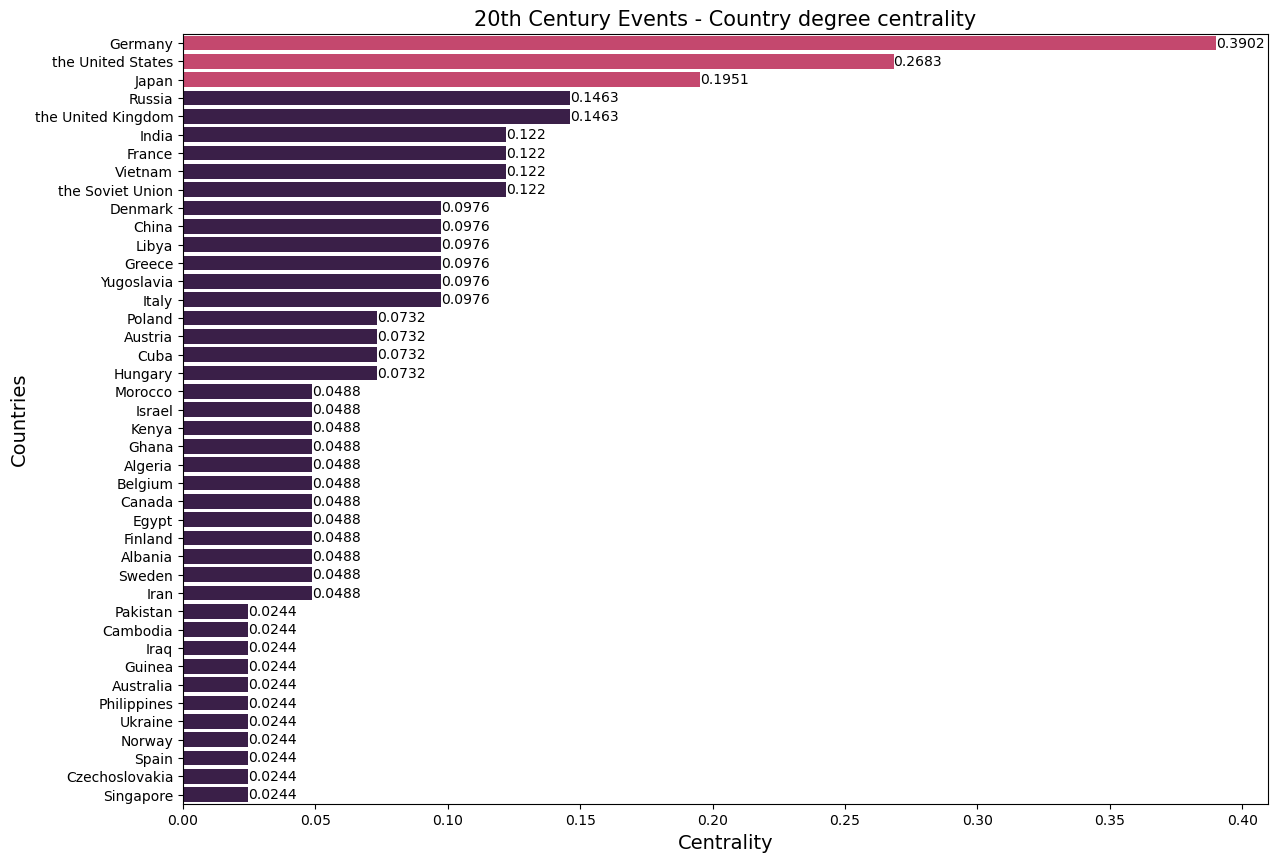

In [27]:
degree_colormap = []
for i in degree_df['Centrality']:
    if (i in set(degree_df['Centrality'].nlargest(3))):
        degree_colormap.append('#cb416b') # Highlight the top three countries
    else: degree_colormap.append ('#3b1d4a')

# Plot the closeness centrality
fig1, ax1 = plt.subplots(figsize = (14, 10))
sns.barplot(x = "Centrality", y = "Countries", palette = degree_colormap,
            saturation = 0.9, data = degree_df)

# Formatting for title and axes
plt.title('20th Century Events - Country degree centrality', fontsize = 15)
plt.xlabel('Centrality', fontsize = 14)
plt.ylabel('Countries', fontsize = 14)

for i in ax1.containers:
    ax1.bar_label(i, color = 'black', label_type = 'edge', padding = 0) # Add data labels

plt.show()

#### Observations about Degree Centrality:
    The three countries with the highest number of connections were Germany, The United States, and 
    Japan (in that order). This makes intuitive sense because Germany was at the center of the two 
    World Wars that dominated global relations in the 20th century. And The United States and Japan 
    were also 
    important factors in those two events. 
    
    Following this, the other countries' scores fall off gradually. And they are ranked in an order 
    that reflects the relative order you may assume these countries were involved in global events 
    (specifically, the two World Wars).

#### CLOSENESS CENTRALITY

In [30]:
# Calculate closeness centrality of network object, and convert output into a sorted dataframe
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame(closeness_dict.items(), columns=['Countries','Centrality'])
closeness_df.sort_values(by = ['Centrality'], ascending=False, inplace = True)
closeness_df['Centrality'] = closeness_df['Centrality'].apply(lambda x: round(x, 4)) # Round centrality measure to 4 decimal places

In [31]:
# Create a new column in dataframe for Leiden communities
closeness_df['Community'] = closeness_df['Countries'].map(dict_com)

# When I can customize the colors of the communities, I will check to see coloring 
# the bar chart by community is a valuable effort

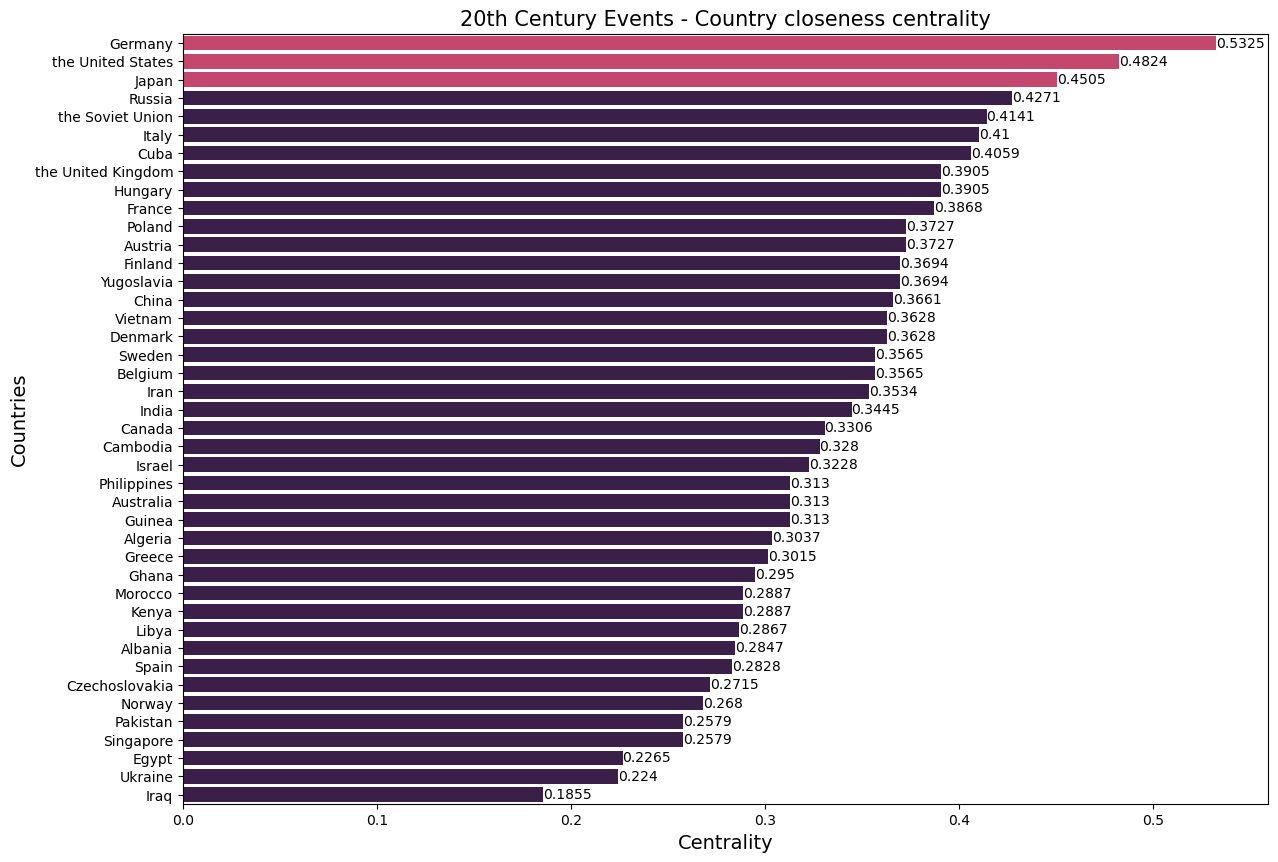

In [32]:
closeness_colormap = []
for i in closeness_df['Centrality']:
    if (i in set(closeness_df['Centrality'].nlargest(3))):
        closeness_colormap.append('#cb416b') # Highlight the top three countries
    else: closeness_colormap.append ('#3b1d4a')

# Plot the closeness centrality
fig2, ax2 = plt.subplots(figsize = (14, 10))
sns.barplot(x = "Centrality", y = "Countries", palette = closeness_colormap,
            saturation = 0.9, data = closeness_df)

# Formatting for title and axes
plt.title('20th Century Events - Country closeness centrality', fontsize = 15)
plt.xlabel('Centrality', fontsize = 14)
plt.ylabel('Countries', fontsize = 14)

for i in ax2.containers:
    ax2.bar_label(i, color = 'black', label_type = 'edge', padding = 0) # Add data labels

plt.show()

#### Observations about Closeness Centrality:
    The order of the countries is roughly the same as the Degree Centrality measure which reinforces 
    that the three countries at the top (Germany, The United States, and Japan) were the most 
    important countries during the 20th century.
    
    However, all of the countries are much closer in score than with the Degree Centrality measure 
    because all of the countries are fairly well-connected to the central players.

#### BETWEENNESS CENTRALITY

In [35]:
# Calculate betweenness centrality of network object, and convert output into a sorted dataframe
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame(betweenness_dict.items(), columns=['Countries','Centrality'])
betweenness_df.sort_values(by = ['Centrality'], ascending=False, inplace = True)
betweenness_df['Centrality'] = betweenness_df['Centrality'].apply(lambda x: round(x, 4)) # Round centrality measure to 4 decimal places

In [36]:
# Create a new column in dataframe for Leiden communities
betweenness_df['Community'] = betweenness_df['Countries'].map(dict_com)

# When I can customize the colors of the communities, I will check to see coloring 
# the bar chart by community is a valuable effort

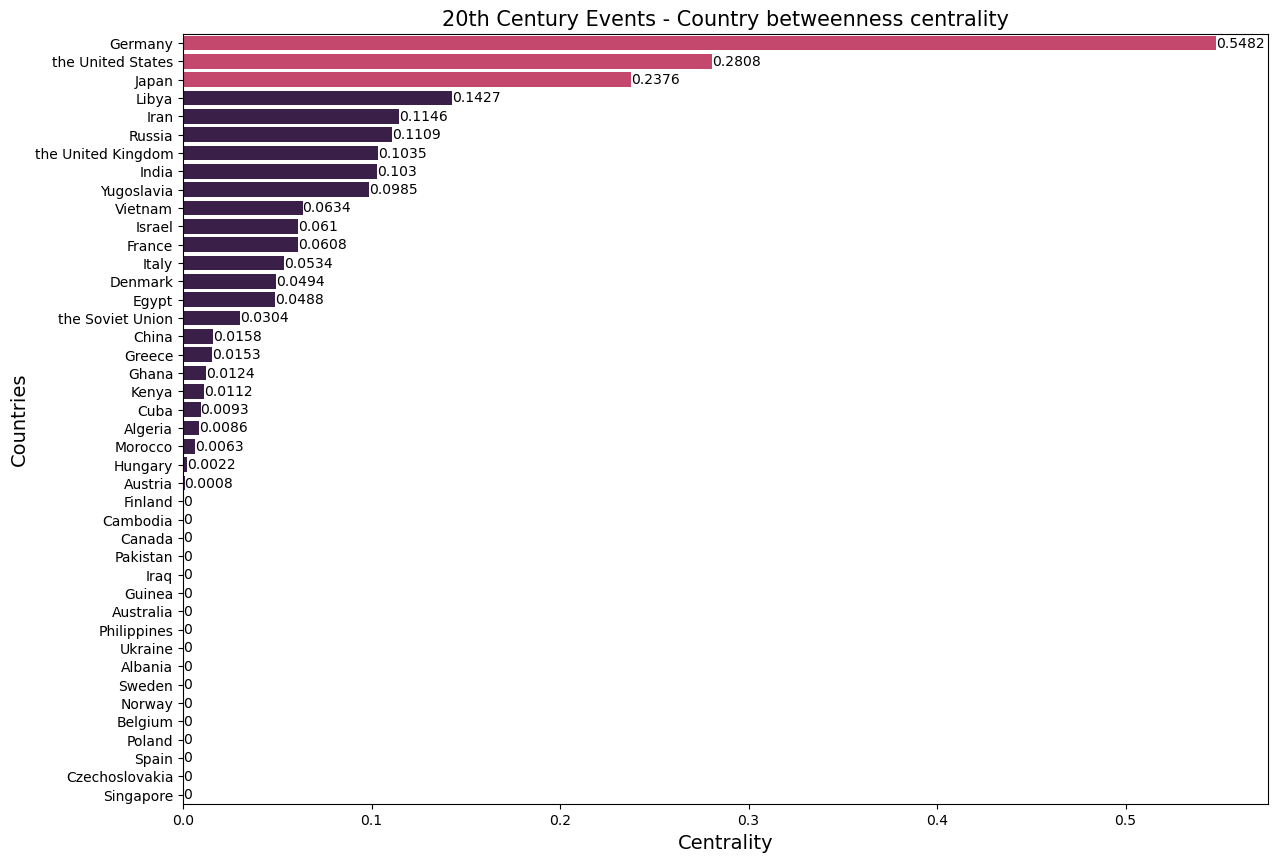

In [37]:
between_colormap = []
for i in betweenness_df['Centrality']:
    if (i in set(betweenness_df['Centrality'].nlargest(3))):
        between_colormap.append('#cb416b') # Highlight the top three countries
    else: between_colormap.append ('#3b1d4a')


# Plot the betweenness centrality
fig3, ax3 = plt.subplots(figsize = (14, 10))
sns.barplot(x = "Centrality", y = "Countries", palette = between_colormap,
            saturation = 0.9, data = betweenness_df)

# Formatting for title and axes
plt.title('20th Century Events - Country betweenness centrality', fontsize = 15)
plt.xlabel('Centrality', fontsize = 14)
plt.ylabel('Countries', fontsize = 14)

for i in ax3.containers:
    ax3.bar_label(i, color = 'black', label_type = 'edge', padding = 0) # Add data labels

plt.show()

#### Observations about Betweenness Centrality:
    Again, Germany, The United States, and Japan formed the top three scores (in that order). With 
    Betweenness, these three countries make sense as the top scorers because they were the most 
    important countries on their continent. It is likely that countries in Asia were most likely 
    to interact with Japan, countries in Europe most likely to interact with Germany, and countries 
    in the Americas most likely to interact with The United States. So, many countries depended on 
    their connections to these three hubs to be connected to other countries on the network graph.
    
    This theory also makes sense because following the top three are two countries that have not 
    been in the top before: Libya and Iran. These countries were likely the most important countries 
    in Africa and the Middle East, respectively. And countries with a score of 0 are countries that


### 8. Export Network Visualizations<a class="anchor" id="export-viz"></a>

In [40]:
# Save centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

In [41]:
# Exporting all centrality measure plots
fig1.figure.savefig(os.path.join(path, '04. Visualizations', 'degree_centrality_20th-Century_countries.png'))
fig2.figure.savefig(os.path.join(path, '04. Visualizations', 'closeness_centrality_20th-Century_countries.png'))
fig3.figure.savefig(os.path.join(path, '04. Visualizations', 'betweenness_centrality_20th-Century_countries.png'))